In [1]:
# Simple demonstration of using standard and heteroscedastic GPs with GPy package to model noisy functions,
# for example some (approximate) log-likelihood function in likelihood-free inference context.
# Initial version, 5/12/2023
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def loglik(th):
    # exact loglik, here 1D Gaussian density
    return -(th-0.45)**2/(2*0.075**2)

def noise_var(th):
    return (0.1+np.abs(loglik(th)))*1.**2 # heteroscedastic noise, here roughly proportional to the loglik value

def noisy_loglik(th):
    # noisy loglik evaluation
    return loglik(th) + np.sqrt(noise_var(th))*np.random.randn(*th.shape)

In [3]:
th_bounds = [0, 1]
th_grid = np.linspace(th_bounds[0], th_bounds[1], 100)

In [4]:
# Get some noisy loglik evaluations
np.random.seed(12345)
n_tr = 50 # how many evaluations to train the GP model
th_tr = np.random.rand(n_tr) # evaluation locations, here just uniformly acquired
th_tr = np.sort(th_tr) # we sort the parameters, this is not necessary
y_tr = noisy_loglik(th_tr) # evaluates noisy loglik

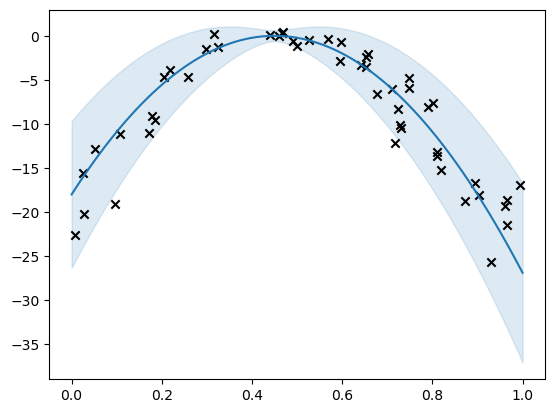

In [5]:
# Plot 'data'
plt.plot(th_grid, loglik(th_grid));
plt.fill_between(th_grid, 
                 loglik(th_grid)-1.96*np.sqrt(noise_var(th_grid)),
                 loglik(th_grid)+1.96*np.sqrt(noise_var(th_grid)), color='tab:blue',alpha=0.15)
plt.scatter(th_tr, y_tr, marker='x', color='k');

In [6]:
# set-up GP models and optimize their hyperparameters
# TODO: SET SPECIAL MEAN FUNCTION

import GPy

th = th_tr.reshape(-1, 1)
y = y_tr.reshape(-1, 1)
kern = GPy.kern.RBF(input_dim=1, variance=5.**2, lengthscale=1.)

# Homoscedastic model for the noisy loglik
m = GPy.models.GPRegression(th,y,kernel=kern.copy())
m.optimize();

# Heteroscedastic model (input-dependent noise variance) for the noisy loglik
m_het = GPy.models.GPHeteroscedasticRegression(th,y,kernel=kern.copy())
m_het.het_Gauss.variance = noise_var(th).reshape(-1, 1)
m_het.het_Gauss.variance.fix()
m_het.optimize();


In [7]:
m

GP_regression.,value,constraints,priors
rbf.variance,523.543365197997,+ve,
rbf.lengthscale,0.48832929266243363,+ve,
Gaussian_noise.variance,6.35155331493979,+ve,


In [8]:
m_het

gp.,value,constraints,priors
rbf.variance,214.68881026704554,+ve,
rbf.lengthscale,0.28109836970371005,+ve,
het_Gauss.variance,"(50, 1)",+ve fixed,


In [9]:
m_het.het_Gauss.variance

index,gp.het_Gauss.variance,constraints,priors
[0 0],17.43519070,+ve fixed,
[1 0],16.18002898,+ve fixed,
[2 0],16.01613648,+ve fixed,
[3 0],14.18335964,+ve fixed,
[4 0],11.24118087,+ve fixed,
[5 0],10.59159700,+ve fixed,
[6 0],7.02345347,+ve fixed,
[7 0],6.67379268,+ve fixed,
[8 0],6.39326211,+ve fixed,
[9 0],5.45472505,+ve fixed,


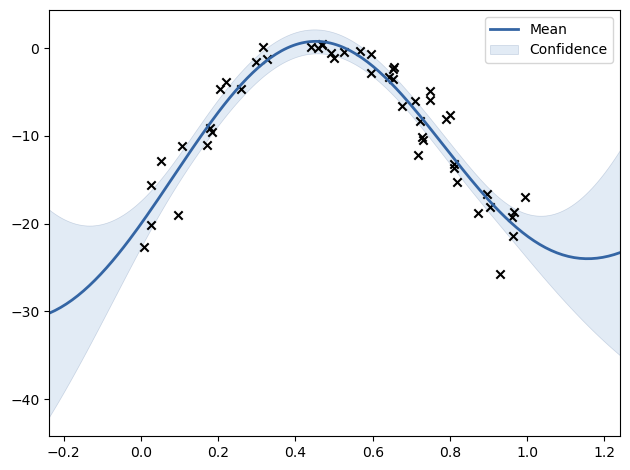

In [10]:
# Plot fitted GP models for the loglik
# First standard GP:
m.plot_f() # m.plot_latent() would do the same
plt.scatter(th_tr, y_tr, marker='x', color='k');

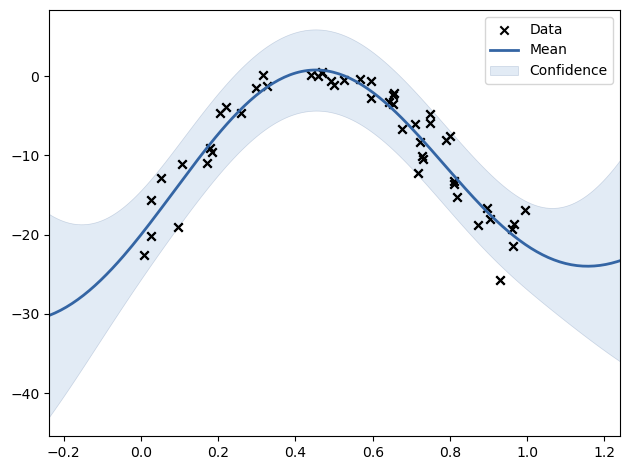

In [11]:
m.plot()
plt.scatter(th_tr, y_tr, marker='x', color='k');
# We see that the predictive variance is overestimated near the mode theta=0.45

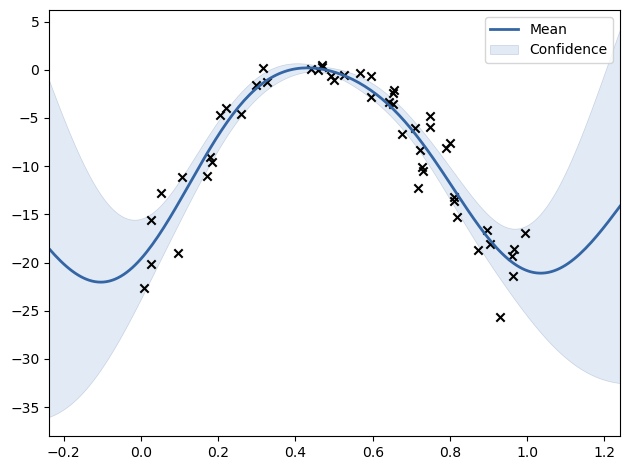

In [12]:
# Heteroscedastic GP model:
m_het.plot_f();
plt.scatter(th_tr, y_tr, marker='x', color='k');
# We see less uncertainty near theta=0.45 and more near the boundaries

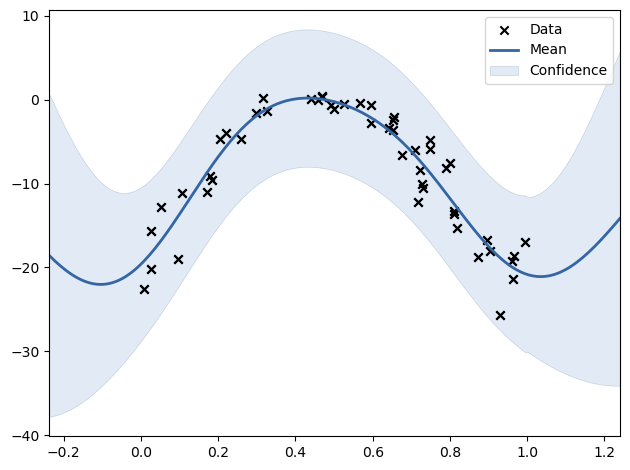

In [13]:
m_het.plot(); # This does not seem to work correctly in the GPy package!
plt.scatter(th_tr, y_tr, marker='x', color='k');

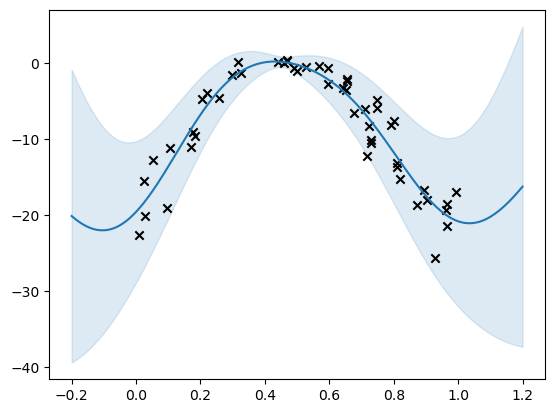

In [14]:
# This works correctly:
th_grid2 = np.linspace(-0.2, 1.2, 200).reshape(-1,1)
m, v_y = m_het.predict_noiseless(th_grid2)
v_y += noise_var(th_grid2) # manually add the known heteroscedastic noise variance to the latent variance
plt.plot(th_grid2, m);
plt.fill_between(np.squeeze(th_grid2), 
                 np.squeeze(m-1.96*np.sqrt(v_y)), 
                 np.squeeze(m+1.96*np.sqrt(v_y)), color='tab:blue',alpha=0.15)
plt.scatter(th_tr, y_tr, marker='x', color='k');

In [15]:
# Some other testing
# Predictive mean and variance, already used above:
th1 = np.array([0.8]).reshape(-1,1)
th2 = np.array([0.9]).reshape(-1,1)
#m_het.predict(th1) # did not work
m_het.predict_noiseless(th1)

(array([[-11.76523894]]), array([[0.72380128]]))

In [16]:
m_het.predict(th1,include_likelihood=False) # as above

(array([[-11.76523894]]), array([[0.72380128]]))

In [17]:
# Predictive covariance:
#m_het.posterior_covariance_between_points(th1,th2) # did not work
m_het.posterior_covariance_between_points(th1,th2,include_likelihood=False)

array([[0.70781404]])